In [4]:
%pip install 'gymnasium[classic-control]' --upgrade

  Obtaining dependency information for gymnasium[classic-control] from https://files.pythonhosted.org/packages/de/85/f5039ce2df5f0789ff1240f08a59f3e8c92e4c5f99543b7aad7388532f7c/gymnasium-1.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 738.5 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib inline
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import sys

<img src="https://stanford-cs221.github.io/autumn2023/assignments/mountaincar/mountaincar.png" width="400">

On considère l'environnement *Mountain Car* où on contrôle une voiture dans une vallée avec pour but d'atteindre le sommet de droite. On dispose de 3 actions: accélérer vers la gauche (0), ne pas accélerer (1), accélérer vers la droite (2). Un état correspond à un couple $(m,v)\in \left[ - 1.2,.6 \right] \times \left[ - .07 ,.07 \right]$ correspondant à la position (l'abscisse) et la vitesse. L'état de départ d'une interaction ("épisode") est choisi aléatoirement mais toujours dans la vallée.

On pourra consulter la documentation officielle pour plus d'informations : https://gymnasium.farama.org/environments/classic_control/mountain_car/

In [6]:
env = gym.make("MountainCar-v0")

In [7]:
def render_policy(policy):
    local_env = gym.make("MountainCar-v0", render_mode='rgb_array')
    s = local_env.reset()[0]
    terminated = False
    truncated = False
    while not (terminated or truncated):
        a = policy(s)
        s, r, terminated, truncated , _ = local_env.step(a)
        clear_output(wait=True)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(local_env.render())
        plt.show()
    plt.close()

La fonction `render_policy` ci-dessus permet de visualiser une politique durant un épisode, sous la forme d'une animation. L'argument `policy` doit être une fonction prenant en argument un état et renvoyant un action (choisie éventuellement de façon aléatoire).

*Question 1* : Visualiser la politique accélérant toujours vers la droite.

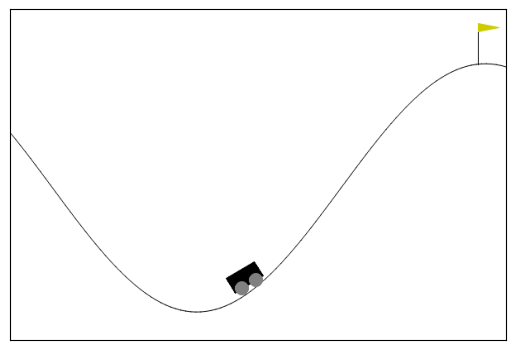

In [8]:
render_policy(lambda s: 2)

*Question 2* : Proposer une meilleure politique et la visualiser. Estimer la longueur moyenne d'un épisode lorsque cette politique est employée.

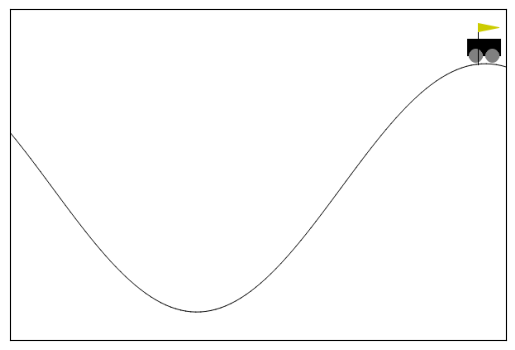

In [9]:
def clever_policy(s):
    m, v = s
    if v > 0:
        return 2
    elif v < 0:
        return 0
    elif v == 0:
        return 1

render_policy(clever_policy)

In [17]:
lengths = []
for episode in range(200):
    s = env.reset()[0]
    terminated = False
    t = 0
    while not terminated:
        a = clever_policy(s)
        s, r, terminated, _, _ = env.step(a)
        t += 1
    lengths.append(t)
print(np.array(lengths).mean())

114.345


Pour le reste du TP, on oublie la description de l'environnement ainsi que l'intuition qu'on en a. On suppose qu'on a seulement la connaissance de l'ensemble des actions, de l'ensemble des états, et qu'on peut iteragir sans limite avec l'envionnement dans le cadre d'épisodes dont on ne choisit pas l'état initial.

L'ensemble d'états étant infini (ou en toute rigueur, fini mais de cardinal très élevé, si on considère que les valeurs sont de type float32), on souhaite construire un algorithme d'apprentissage par renforcement s'appuyant sur une famille paramétrique de fonctions valeur. 

On fait le choix d'une paramétrisation linéaire de fonctions
action-valeur en dimension 1200 $(q_w)_{w\in \mathbb{R}^{1200}}$:
$ q_w(s,a)=\phi(s,a)^{\top}\!w,$
où la *feature map* $\phi:\mathcal{S}\times \mathcal{A}\to \mathbb{R}^{1200}$
est construite de la façon suivante à l'aide d'une application
$\psi:\mathcal{S}\to \mathbb{R}^{400}$:

$ \phi(s,0)=(\psi(s)|0_{\mathbb{R}^{800}})^{\top} $

$ \phi(s,1)=(0_{\mathbb{R}^{400}}|\psi(s)|0_{\mathbb{R}^{400}})^{\top} $

$ \phi(s,2)=(0_{\mathbb{R}^{800}}|\psi(s))^{\top} $

On construit la fonction $\psi$ de la façon suivante,
en effectuant d'abord une normalisation (sur la base de 10000 exemples de valeurs d'état), puis en utilisant la fonction `RBFSampler` de `scikit-learn` qui permet d'approximer en dimension finie la `feature map` d'un noyau gaussien.

In [21]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

def psi(s):
    return np.squeeze(featurizer.transform(scaler.transform(s[np.newaxis,:])))

*Question 3* : Compléter les fonctions suivantes qui calculent $\phi(s,a)$ et $q_w(s,a)$ selon les définitions données plus haut. *On pourra faire appel à la fonction `np.concatenate`.*

In [28]:
def phi(s,a):
    z = np.zeros(400)
    if a == 0:
        l = [psi(s),z,z]
    elif a == 1:
        l = [z,psi(s),z]
    elif a == 2:
        l = [z,z,psi(s)]
    return np.concatenate(l)

def q(s,a,w):
    return np.dot(phi(s, a), w)

*Question 4* : En s'inspirant des TP précédents, écrire une fonction `draw_action_greedy_policy` qui tire une action selon une politique $\epsilon$-gloutonne par rapport à une fonction action-valeur $q_w$ de la famille paramétrique.

In [29]:
def draw_action_greedy_policy(s, w, eps=0):
    if np.random.binomial(1, eps) == 1:
        return np.random.randint(low=0, high=3)
    else:
        qs = np.array([q(s,0,w), q(s,1,w), q(s,2,w)])
        Argmax = list(np.where(qs==qs.max())[0]) 
        index = np.random.randint(low=0, high=len(Argmax))
        return Argmax[index]

*Question 5* : Implémenter un Q-learning (semi-gradient). Essayer plusieurs valeurs pour $\alpha$. Visualiser la politique obtenue au bout de 10 épisodes (puis 20, 50, 100, 200 épisodes). Tracer l'évolution de la longueur des épisodes.

Step 16830 @ Episode 100/100

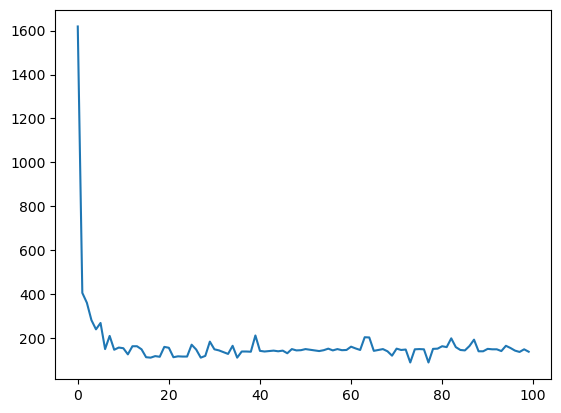

In [37]:
episode_lengths = []
n_episodes = 100
alpha = .05
w = np.zeros(400*3)
k = 0
gamma = .99
eps = 0.1

for episode in range(n_episodes):
    sys.stdout.flush()

    s = env.reset()[0]

    terminated = False
    truncated = False

    episode_lengths.append(0)

    # on ignore le signal de troncation, afin d'aller au-delà de la limite des 200 étapes par épisode
    while not terminated:
        a = draw_action_greedy_policy(s, w, eps)
        s_, r, terminated, truncated, _ = env.step(a)

        episode_lengths[-1] += 1

        w = w + alpha*(r + gamma * max([q(s_,0,w), q(s_,1,w), q(s_,2,w)])-q(s,a,w))*phi(s,a)
        s = s_

        print("\rStep {} @ Episode {}/{}".format(k, episode + 1, n_episodes), end="")

        k += 1
env.close()

plt.plot(episode_lengths)
plt.show()

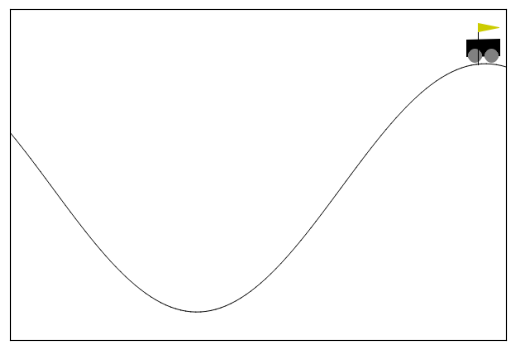

In [34]:
def resulting_policy(s):
    return draw_action_greedy_policy(s,w,0)

render_policy(resulting_policy)

*Question 6* : Même question avec SARSA (à n étapes) (semi-gradient).

Step 24004 @ Episode 100/100

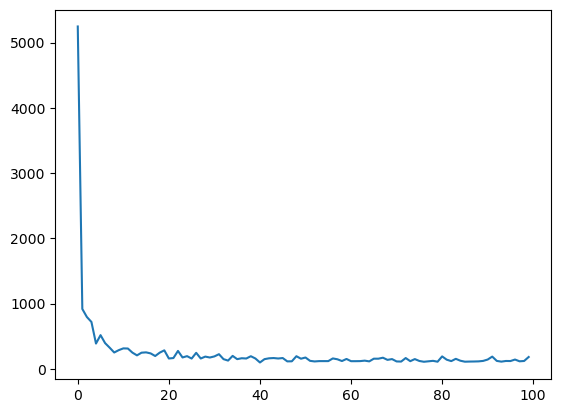

In [35]:
episode_lengths = []
n_episodes = 100
alpha = .01
w = np.zeros(400*3)
k = 0
gamma = .99
eps = 0.1

for episode in range(n_episodes):
    sys.stdout.flush()

    s = env.reset()[0]

    terminated = False
    truncated = False

    episode_lengths.append(0)
    a = draw_action_greedy_policy(s, w, eps)

    while not terminated:
        s_, r, terminated, truncated, _ = env.step(a)        

        episode_lengths[-1] += 1
        
        a_ = draw_action_greedy_policy(s_, w, eps)

        # Ici: SARSA à 1 étape
        w = w + alpha*(r + gamma * q(s_,a_,w)-q(s,a,w))*phi(s,a)
        s = s_
        a = a_

        print("\rStep {} @ Episode {}/{}".format(k, episode + 1, n_episodes), end="")

        k += 1
env.close()

plt.plot(episode_lengths)
plt.show()

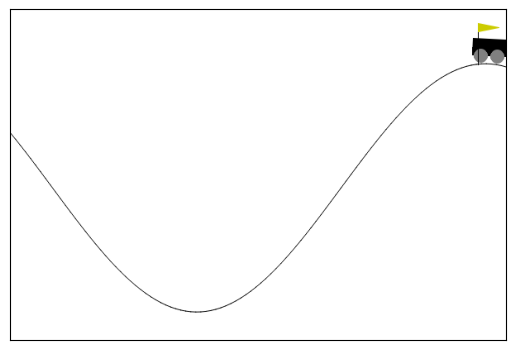

In [36]:
def resulting_policy(s):
    return draw_action_greedy_policy(s,w,0)

render_policy(resulting_policy)